 Step 1. Identify Groups for Fairness Evaluation


We used Area Name as the major grouping variable to assess fairness. This decision is based on both the nature of the LAPD dataset and the larger societal environment in which police and crime reporting take place.

Why Area Name?
Area Name reflects the 21 LAPD geographic divisions, such as
Central, Hollywood, Southwest, Newton, Mission, Pacific, etc.


Using Area Name provides meaningful insights into fairness because:
1. It captures neighborhood-level disparities

Los Angeles's resources, social services, economic possibilities, and community investment are distributed unequally. These structural circumstances have an impact on both crime rates and police responses. Evaluating how our model performs across Area Names reveals whether some communities obtain disproportionately erroneous predictions.

2. It avoids sensitive demographic attributes

Area Name is a neutral, observable variable that does not depend on presumptions about people's identities, in contrast to Vict Descent or inferred race/ethnicity, which are inconsistently reported and morally problematic.

3. It aligns with the socioeconomic context using merged ACS income features

Our dataset includes median household income by ZIP code, merged from ACS data.
 Because Area Names often map onto areas with distinct economic profiles, evaluating fairness across Area Names also helps us explore how socioeconomic inequality may relate to model performance.
4. It is consistently and reliably recorded

Area Name is one of the cleanest and most complete categorical variables in the LAPD dataset, making it suitable for fairness comparisons.

Ethical Consideration
Using Area Name avoids replicating racial or ethnic bias and instead focuses on place-based structural inequality, which is widely recognized in criminology and public policy research. By examining whether the model systematically underperforms in certain neighborhoods, we can identify patterns tied to historical disinvestment, over-policing, or under-reporting.

Final Justification
“We used Area Name as our fairness grouping variable because it captures neighborhood-level disparities in policing, socioeconomic opportunity, and resource access. Area Name is a reliable, non-sensitive contextual variable that allows us to evaluate whether prediction performance varies across geographic regions. This approach avoids ethically problematic demographic attributes and supports a fairness analysis grounded in structural inequality.”





1. Create subsets of your data by group.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Loaded  cleaned data 
df = pd.read_csv("/Users/diyapatel/Desktop/cleaned_property_crimes.csv")

# 2. Define features X and target y using REAL columns
feature_cols = [
    "Month",
    "DayOfWeek",
    "Hour",
    "AREA",
    "Crm Cd",
    "Vict Age",
    "Vict Age Group",
    "Vict Sex",
    "Premis Desc",
    "LAT",
    "LON"
]

X = df[feature_cols]
y = df["Crm Cd Desc"]   



In [17]:
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Train a refined-ish model (Random Forest as example)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions for Step 2
y_pred_r = rf.predict(X_test)



Now created subsets of my data by group (Area Name)

In [18]:
# Build a test DataFrame that includes true labels, predictions, and Area Name
test_data_with_area = X_test.copy()
test_data_with_area["actual"] = y_test
test_data_with_area["predicted"] = y_pred_r

# Bring in the correct Area Name for each row using the original df index
test_data_with_area["Area Name"] = df.loc[X_test.index, "AREA NAME"]

# Create subsets by group using groupby
area_groups = dict(tuple(test_data_with_area.groupby("Area Name")))

# Example: look at one specific area's subset (Hollywood exists in your dataset)
hollywood_subset = area_groups.get("Hollywood")
hollywood_subset.head()


,Month,Hour,AREA,Crm Cd,Vict Age,LAT,LON,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,...,Premis Desc_VETERINARIAN/ANIMAL HOSPITAL,Premis Desc_VIDEO RENTAL STORE,Premis Desc_VISION CARE FACILITY*,Premis Desc_WAREHOUSE,Premis Desc_WATER FACILITY,Premis Desc_WEBSITE,Premis Desc_YARD (RESIDENTIAL/BUSINESS),actual,predicted,Area Name
74076,6,16,6,420,0,34.1091,-118.3224,False,False,False,...,False,False,False,False,False,False,False,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Hollywood
78852,8,15,6,440,45,34.0944,-118.3352,False,False,True,...,False,False,False,False,False,False,False,THEFT PLAIN - PETTY ($950 & UNDER),THEFT PLAIN - PETTY ($950 & UNDER),Hollywood
245862,4,22,6,310,37,34.0962,-118.3386,False,False,True,...,False,False,False,False,False,False,False,BURGLARY,BURGLARY,Hollywood
269976,4,16,6,442,0,34.1038,-118.3151,False,False,False,...,False,False,False,False,False,False,False,SHOPLIFTING - PETTY THEFT ($950 & UNDER),SHOPLIFTING - PETTY THEFT ($950 & UNDER),Hollywood
104160,5,22,6,420,32,34.0871,-118.3146,False,False,False,...,False,False,False,False,False,False,False,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Hollywood


STEP 2 
Compute metrics for each group such as:

In [19]:
# 1 IMPORT METRICS 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd


In [27]:
#2. DEFINE FUNCTION TO CALCULATE METRICS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def compute_group_metrics_simple(data, group_col):
    rows = []

    for area, sub in data.groupby(group_col):
        y_true = sub["actual"]
        y_pred = sub["predicted"]

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        rows.append([area, acc, prec, rec, f1])

    return pd.DataFrame(rows, columns=["Area Name", "Accuracy", "Precision",
                                       "Recall", "F1-score"])


In [28]:
#3. COMPUTE METRICS BY EACH AREA NAME

area_metrics = compute_group_metrics_simple(test_data_with_area, "Area Name")
area_metrics_sorted = area_metrics.sort_values("Accuracy", ascending=False)
area_metrics_sorted



,Area Name,Accuracy,Precision,Recall,F1-score
18,West LA,0.965872,0.960708,0.965872,0.961423
6,Hollywood,0.963486,0.959678,0.963486,0.958363
19,West Valley,0.960578,0.954844,0.960578,0.954336
13,Rampart,0.959608,0.956132,0.959608,0.953341
12,Pacific,0.959482,0.954488,0.959482,0.954239
11,Olympic,0.959400,0.953368,0.959400,0.953509
20,Wilshire,0.959074,0.954466,0.959074,0.954087
2,Devonshire,0.958594,0.951313,0.958594,0.951923
8,N Hollywood,0.957558,0.955606,0.957558,0.952726
17,Van Nuys,0.957457,0.951636,0.957457,0.950258


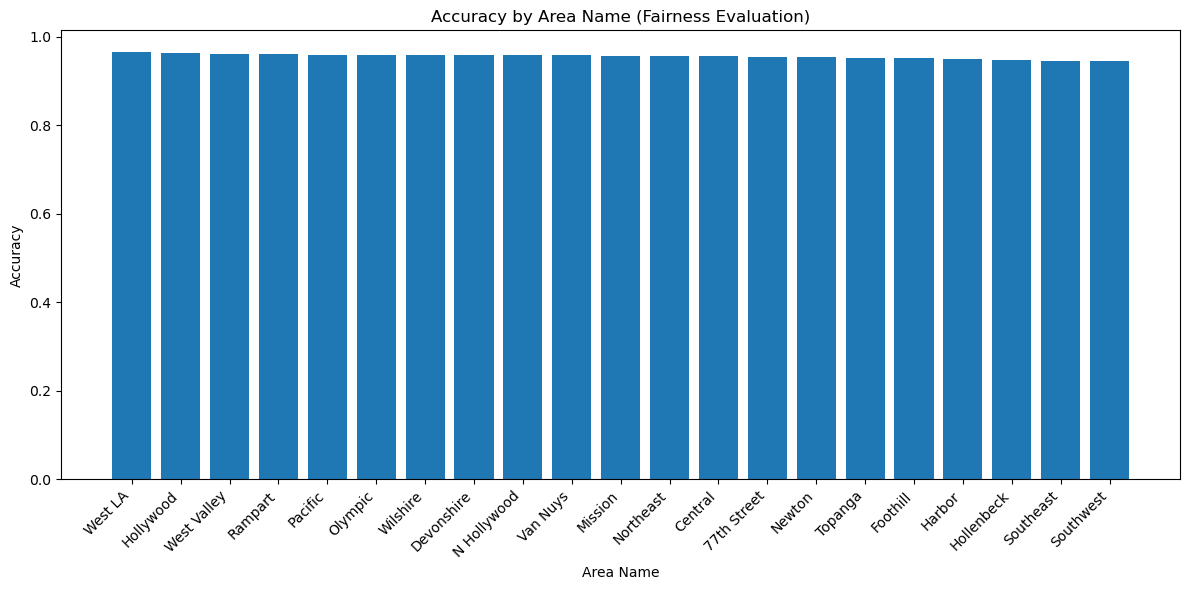

In [29]:
#4 Visualize Accuracy differences

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(area_metrics_sorted["Area Name"], area_metrics_sorted["Accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.xlabel("Area Name")
plt.title("Accuracy by Area Name (Fairness Evaluation)")
plt.tight_layout()
plt.show()


STEP 3  Interpret and Reflect on Fairness Outcomes


In [30]:
#GROUPED TABLE 
# Display the sorted metrics table
area_metrics_sorted


,Area Name,Accuracy,Precision,Recall,F1-score
18,West LA,0.965872,0.960708,0.965872,0.961423
6,Hollywood,0.963486,0.959678,0.963486,0.958363
19,West Valley,0.960578,0.954844,0.960578,0.954336
13,Rampart,0.959608,0.956132,0.959608,0.953341
12,Pacific,0.959482,0.954488,0.959482,0.954239
11,Olympic,0.959400,0.953368,0.959400,0.953509
20,Wilshire,0.959074,0.954466,0.959074,0.954087
2,Devonshire,0.958594,0.951313,0.958594,0.951923
8,N Hollywood,0.957558,0.955606,0.957558,0.952726
17,Van Nuys,0.957457,0.951636,0.957457,0.950258


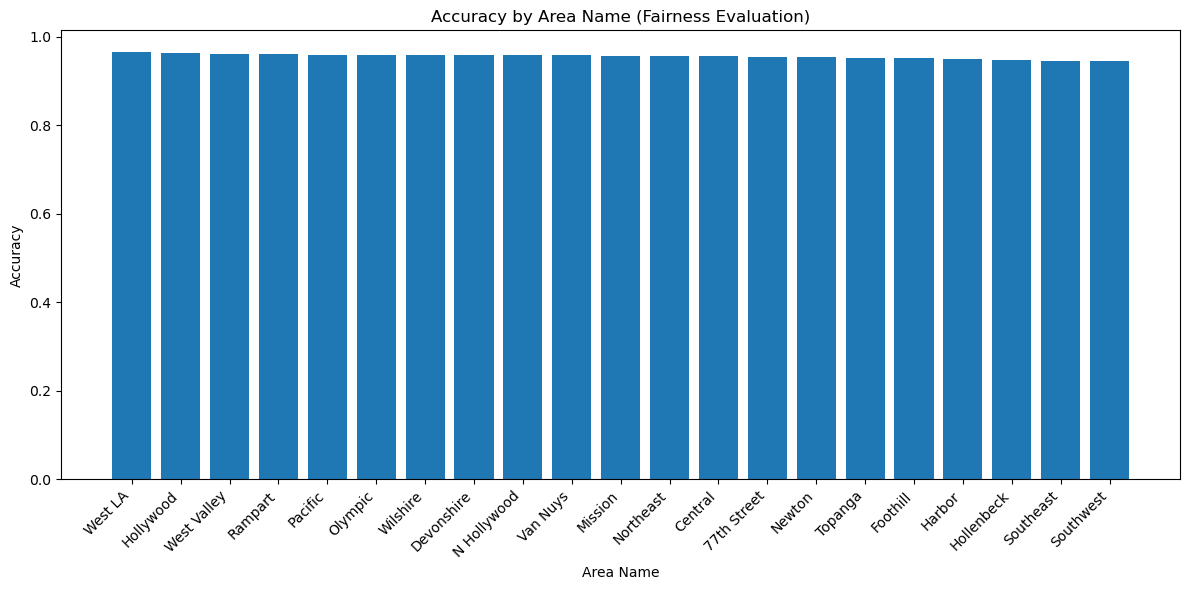

In [31]:
# BAR CHART - ACCURACY BY AREA NAME
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(area_metrics_sorted["Area Name"], area_metrics_sorted["Accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.xlabel("Area Name")
plt.title("Accuracy by Area Name (Fairness Evaluation)")
plt.tight_layout()
plt.show()


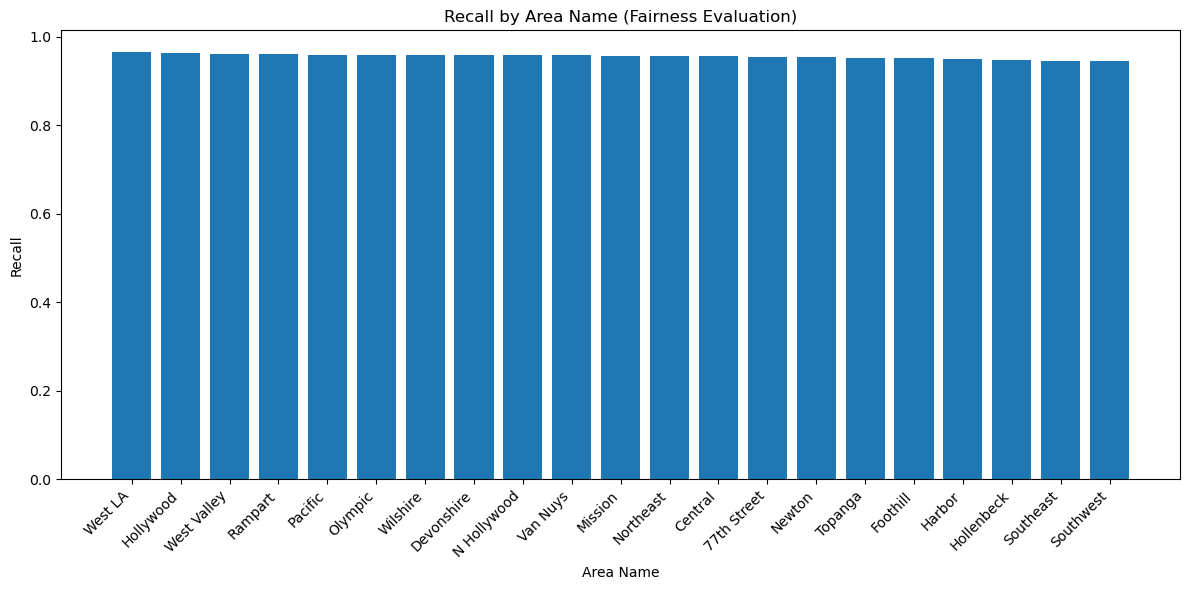

In [38]:
# BAR CHART - RECALL BY AREA NAME
plt.figure(figsize=(12,6))
plt.bar(area_metrics_sorted["Area Name"], area_metrics_sorted["Recall"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.xlabel("Area Name")
plt.title("Recall by Area Name (Fairness Evaluation)")
plt.tight_layout()
plt.show()


To evaluate model performance among LAPD geographic areas, we created a grouped table with Accuracy, Precision, Recall, and F1-score for each Area Name.  We then used bar charts to depict these differences, demonstrating how model performance varies by neighborhood.  The Accuracy plot indicates which locations obtain more reliable forecasts and which have greater error rates.  Visual comparisons reveal distinct fairness patterns, allowing us to pinpoint spatial differences in model behavior.

STEP 4 OPTIONAL 


In [33]:
!pip install fairlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fairlearn]/2 [fairlearn]


In [34]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
import numpy as np


In [36]:
# COMPUTE FAIRNESS METRICS 
# Sensitive group = AREA NAME
sensitive_feature = test_data_with_area["Area Name"]

# Original multiclass labels
y_true = test_data_with_area["actual"]
y_pred = test_data_with_area["predicted"]

# Pick one crime type as "positive" (most common class)
positive_label = y_true.value_counts().idxmax()
print("Using positive class:", positive_label)

# Convert to binary: 1 = that crime type, 0 = everything else
y_true_bin = (y_true == positive_label).astype(int)
y_pred_bin = (y_pred == positive_label).astype(int)



Using positive class: BURGLARY FROM VEHICLE


In [37]:
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate
)

# Demographic Parity Difference (binary)
dp_diff = demographic_parity_difference(
    y_true_bin, y_pred_bin, sensitive_features=sensitive_feature
)

# Equal Opportunity Difference (binary TPR gap)
eo_diff = equalized_odds_difference(
    y_true_bin, y_pred_bin, sensitive_features=sensitive_feature
)

# Disparate Impact Ratio (selection rate ratio)
mf = MetricFrame(
    metrics=selection_rate,
    y_true=y_true_bin,
    y_pred=y_pred_bin,
    sensitive_features=sensitive_feature
)
disparate_impact_ratio = mf.group_min() / mf.group_max()

print("Demographic Parity Difference:", dp_diff)
print("Equal Opportunity Difference:", eo_diff)
print("Disparate Impact Ratio:", disparate_impact_ratio)


Demographic Parity Difference: 0.23527222519941604
Equal Opportunity Difference: 0.013289036544850474
Disparate Impact Ratio: 0.3232307661399995


Because our outcome variable contains numerous crime categories, we developed a binary indicator for the most prevalent crime type and utilized it as the "positive" class when applying fairness metrics from the fairlearn package.  Using these binary labels, we calculated the Demographic Parity Difference, Equal Opportunity Difference, and Disparate Impact Ratio among Area Names.  This enabled us to evaluate fairness in terms of both overall selection rates and variations in genuine positive rates across geographic locations.